<a href="https://colab.research.google.com/github/Liping-LZ/BDAI_2324/blob/main/Text%20analysis/British_Airway_review_analysis_by_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modelling for review analysis**

Latent Dirichlet Allocation (LDA) is a classic model to do topic modelling. Topic modeling is unsupervised learning and the goal is to group different documents to the same “topic”.

## **1. import data you would like to analyse**

In [3]:
# Let's import data first
# Run the code and upload the csv file from your laptop
from google.colab import files
uploaded = files.upload()

Saving british_airways_reviews.v4.csv to british_airways_reviews.v4.csv


In [4]:
import pandas as pd

data = 'british_airways_reviews.v4.csv'
df = pd.read_csv(data) # change the csv file name to your file name that you uploaded
df.head()

,Unnamed: 0,title,reviews,published_dates,user_name,user_location,user_ratings,trip_details,would_recommed_to_others
0,0,“Worst service ever”,Worst service ever. Lost baggage because of d...,23rd January 2024,Chirag Thummar,Germany,1,Type Of TravellerSolo Leisure\nSeat TypeEconom...,n
1,1,"""unprofessional attitude of the pilots""",BA 246 21JAN 2023 Did not appreciate the unp...,21st January 2024,D Carreno,United Kingdom,6,AircraftA350\nType Of TravellerBusiness\nSeat ...,n
2,2,“Next time it will be Jet2”,Not a great experience. I could not check in ...,18th January 2024,Simon Channon,United Kingdom,3,AircraftA320\nType Of TravellerCouple Leisure\...,n
3,3,“become the Ryanair of long-haul travel”,I was excited to fly BA as I'd not travelled ...,18th January 2024,Melissa Harris,United Kingdom,2,Type Of TravellerFamily Leisure\nSeat TypeEcon...,n
4,4,“They never help us”,I just want to warn everyone of the worst cu...,17th January 2024,Ivana Squassabia,Germany,1,Type Of TravellerFamily Leisure\nSeat TypeBusi...,n


<Axes: ylabel='would_recommed_to_others'>

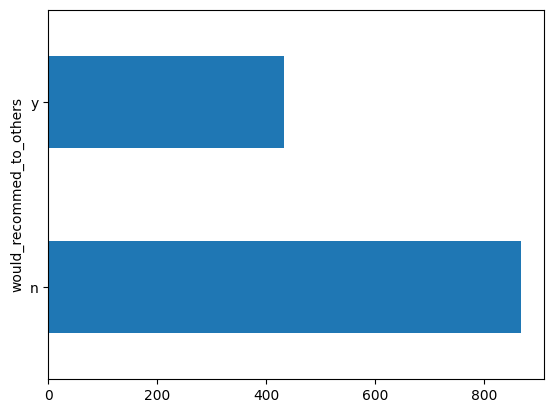

In [22]:
df['would_recommed_to_others'].value_counts().plot(kind='barh')

In [5]:
target_column = 'reviews' #change the column name to where the review is

## **2. Text cleaning & Text processing**
Before you do topic modeling, you need make sure you clean and process the text.

In [6]:
!pip install contractions
import re
import string
import contractions
import nltk
import gensim
from gensim.utils import simple_preprocess
import spacy
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# drop data with missing values in the 'content' column
df = df.dropna(subset=[target_column])

# drop duplicate review content
df = df.drop_duplicates(subset=[target_column])

# remove contraction
df[target_column] = df[target_column].map(lambda x: contractions.fix(x))

# convert the relevant column to lowercase
df[target_column] = df[target_column].str.lower()

# Remove overspace
df[target_column] = df[target_column].map(lambda x: re.sub('\s{2,}', " ", x))

# Remove non-word characters, so numbers and ___ etc
df[target_column] = df[target_column].str.replace("[^A-Za-z]", " ", regex = True)

# Remove punctuation
df[target_column] = df[target_column].map(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [12]:
# create a list of the contents from the 'contents' column
words = df[target_column].tolist()

# tokenise the words
word_tokens = []
for content in words:
    word_tokens.append(word_tokenize(content))

# create bigram model
bigram = gensim.models.phrases.Phrases(word_tokens, min_count=3, threshold=10)
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence clubbed as a trigram/bigram

# NLTK Stop words
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['flight']) #add more stopwords here

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define functions for stopwords, bigrams and lemmatisation
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove stopwords
data_words_nostops = remove_stopwords(word_tokens)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatisation keeping only noun, adj, vb, adv
data_lemmatised = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# put the tokens back together as text to have our filtered contents

rejoin = []
for content in data_lemmatised: # Here we choose to use stemming instead of lemmatisation
    x = " ".join(content) # join the text back together
    rejoin.append(x)

# add the reformed text to the data frame
df['cleaned_review'] = rejoin

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df.head()

,Unnamed: 0,title,reviews,published_dates,user_name,user_location,user_ratings,trip_details,would_recommed_to_others,cleaned_review
0,0,“Worst service ever”,worst service ever lost baggage because of d...,23rd January 2024,Chirag Thummar,Germany,1,Type Of TravellerSolo Leisure\nSeat TypeEconom...,n,bad service ever lost_baggage delay miss conne...
1,1,"""unprofessional attitude of the pilots""",ba jan did not appreciate the unpr...,21st January 2024,D Carreno,United Kingdom,6,AircraftA350\nType Of TravellerBusiness\nSeat ...,n,appreciate unprofessional attitude pilot sched...
2,2,“Next time it will be Jet2”,not a great experience i could not check in ...,18th January 2024,Simon Channon,United Kingdom,3,AircraftA320\nType Of TravellerCouple Leisure\...,n,great experience check online separate part ba...
3,3,“become the Ryanair of long-haul travel”,i was excited to fly ba as i would not travel...,18th January 2024,Melissa Harris,United Kingdom,2,Type Of TravellerFamily Leisure\nSeat TypeEcon...,n,excited fly travel yrs travel australia many o...
4,4,“They never help us”,i just want to warn everyone of the worst cus...,17th January 2024,Ivana Squassabia,Germany,1,Type Of TravellerFamily Leisure\nSeat TypeBusi...,n,want warn bad customer_service experience ever...


### **2.1 Data split**
Split the dataset into two: positive (who would recommend); negative (who would not recommend).

In [23]:
pos = df[df['would_recommed_to_others']=='y']
neg = df[df['would_recommed_to_others']=='n']

## **3. Build the LDA model**

### 3.1 Build LDA model using positive review

we use `vectorizer_pos` to name the vectorizer and use `vec_pos` to get the vector matrix and use `lda_pos` to name the lda model. Since the dataset is smaller, we set k to 3 (3 topics).

In [36]:
# vectorise the data into word counts

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

max_words = 1000 #how many words taking account for topic modeling
vectorizer_pos = CountVectorizer(max_features=max_words)
vec_pos = vectorizer_pos.fit_transform(pos['cleaned_review'])

k = 3 #this is the number of the topic. you can decide the number

lda_pos = LDA(n_components=k, max_iter=5, learning_method='online', random_state = 10)
lda_pos.fit(vec_pos)

LatentDirichletAllocation(learning_method='online', max_iter=5, n_components=3,
                          random_state=10)

### 3.2 Build LDA model using negative review

we use `vectorizer_neg` to name the vectorizer and use `vec_neg` to get the vector matrix and use `lda_neg` to name the lda model. Since the dataset is smaller, we set k to 3 (3 topics).

In [44]:
# vectorise the data into word counts

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

max_words = 1000 #how many words taking account for topic modeling
vectorizer_neg = CountVectorizer(max_features=max_words)
vec_neg = vectorizer_neg.fit_transform(neg['cleaned_review'])

k = 3 #this is the number of the topic. you can decide the number

lda_neg = LDA(n_components=k, max_iter=5, learning_method='online', random_state = 10)
lda_neg.fit(vec_neg)

LatentDirichletAllocation(learning_method='online', max_iter=5, n_components=3,
                          random_state=10)

## **4. Visualisation of the topics**

### 4.1 Visualise the topics out of positive review

We use `vectorizer_pos` to name the vectorizer. Thus,

`terms = vectorizer_pos.get_feature_names_out()`

And we use `lda_pos` to name the lda model. Thus,

`for idx,topic in enumerate(lda_pos.components_)`


Also, we change the topic number to 3. Thus,

`fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True) `

(we change the row to 1 and column to 3)

Topic#  1
seat,good,food,service,crew,time,fly,well,check,comfortable,experience,cabin,get,flight,friendly,really,great,aircraft,ba,offer,board,drink,boarding,lounge,staff,also,take,passenger,british_airway,give,plane,feel,old,make,go,economy,business_class,excellent,new,quite,first,nice,return,however,overall,cabin_crew,serve,work,meal,bag

Topic#  2
thank,make,go,get,help,call,amazing,british_airway,service,ask,travel,crew,assistance,great,check,time,journey,staff,helpful,book,take,give,ba,cabin_crew,well,use,wish,manage,come,alone,fly,professional,provide,say,lady,back,way,review,meet,excellent,know,return,put,tea,people,plane,see,never,airline,business_class

Topic#  3
good,time,lounge,seat,drink,fine,food,offer,well,meal,boarding,service,crew,get,take,use,quick,check,excellent,breakfast,serve,efficient,heathrow,experience,arrival,cabin_crew,hour,aircraft,full,sleep,gate,overall,give,make,small,delay,choice,departure,security,short,board,seem,cheese,plenty,fly,minute,land,clean,pas

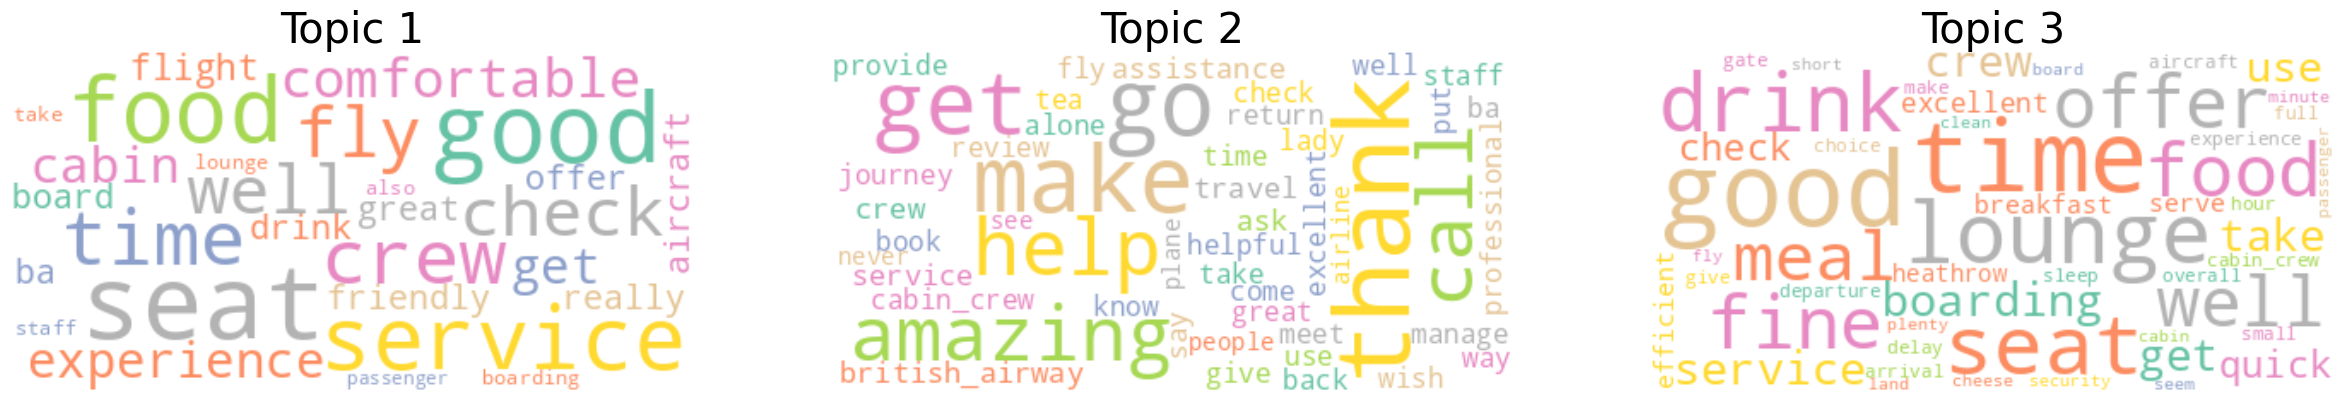

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import wordcloud

#declaring number of terms we need per topic
terms_count = 50

terms = vectorizer_pos.get_feature_names_out() # Make sure you set the right vectorizer name

wcloud = wordcloud.WordCloud(background_color="White",mask=None, max_words=100,\
                             max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                             contour_width=3,contour_color='Black',colormap='Set2')

fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True) # Here you change the structure of the plot; first number is row and second number is column
axes = axes.flatten()

for idx,topic in enumerate(lda_pos.components_): # Make sure you set the right lda model name
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
    print(','.join( word for word in topic_words))
    print("")
    dict_word_frequency = {}

    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]

    ax = axes[idx]
    ax.set_title(f'Topic {idx +1}',fontdict={'fontsize': 30})
    wcloud.generate_from_frequencies(dict_word_frequency)
    ax.imshow(wcloud, interpolation='bilinear')
    ax.axis("off")

Make sure it is `vectorizer_pos` and `lda_pos`

`vec_feature_names = vectorizer_pos.get_feature_names_out()`

`plot_top_words(lda_pos, vec_feature_names, n_top_words, 'Topics in LDA model')`

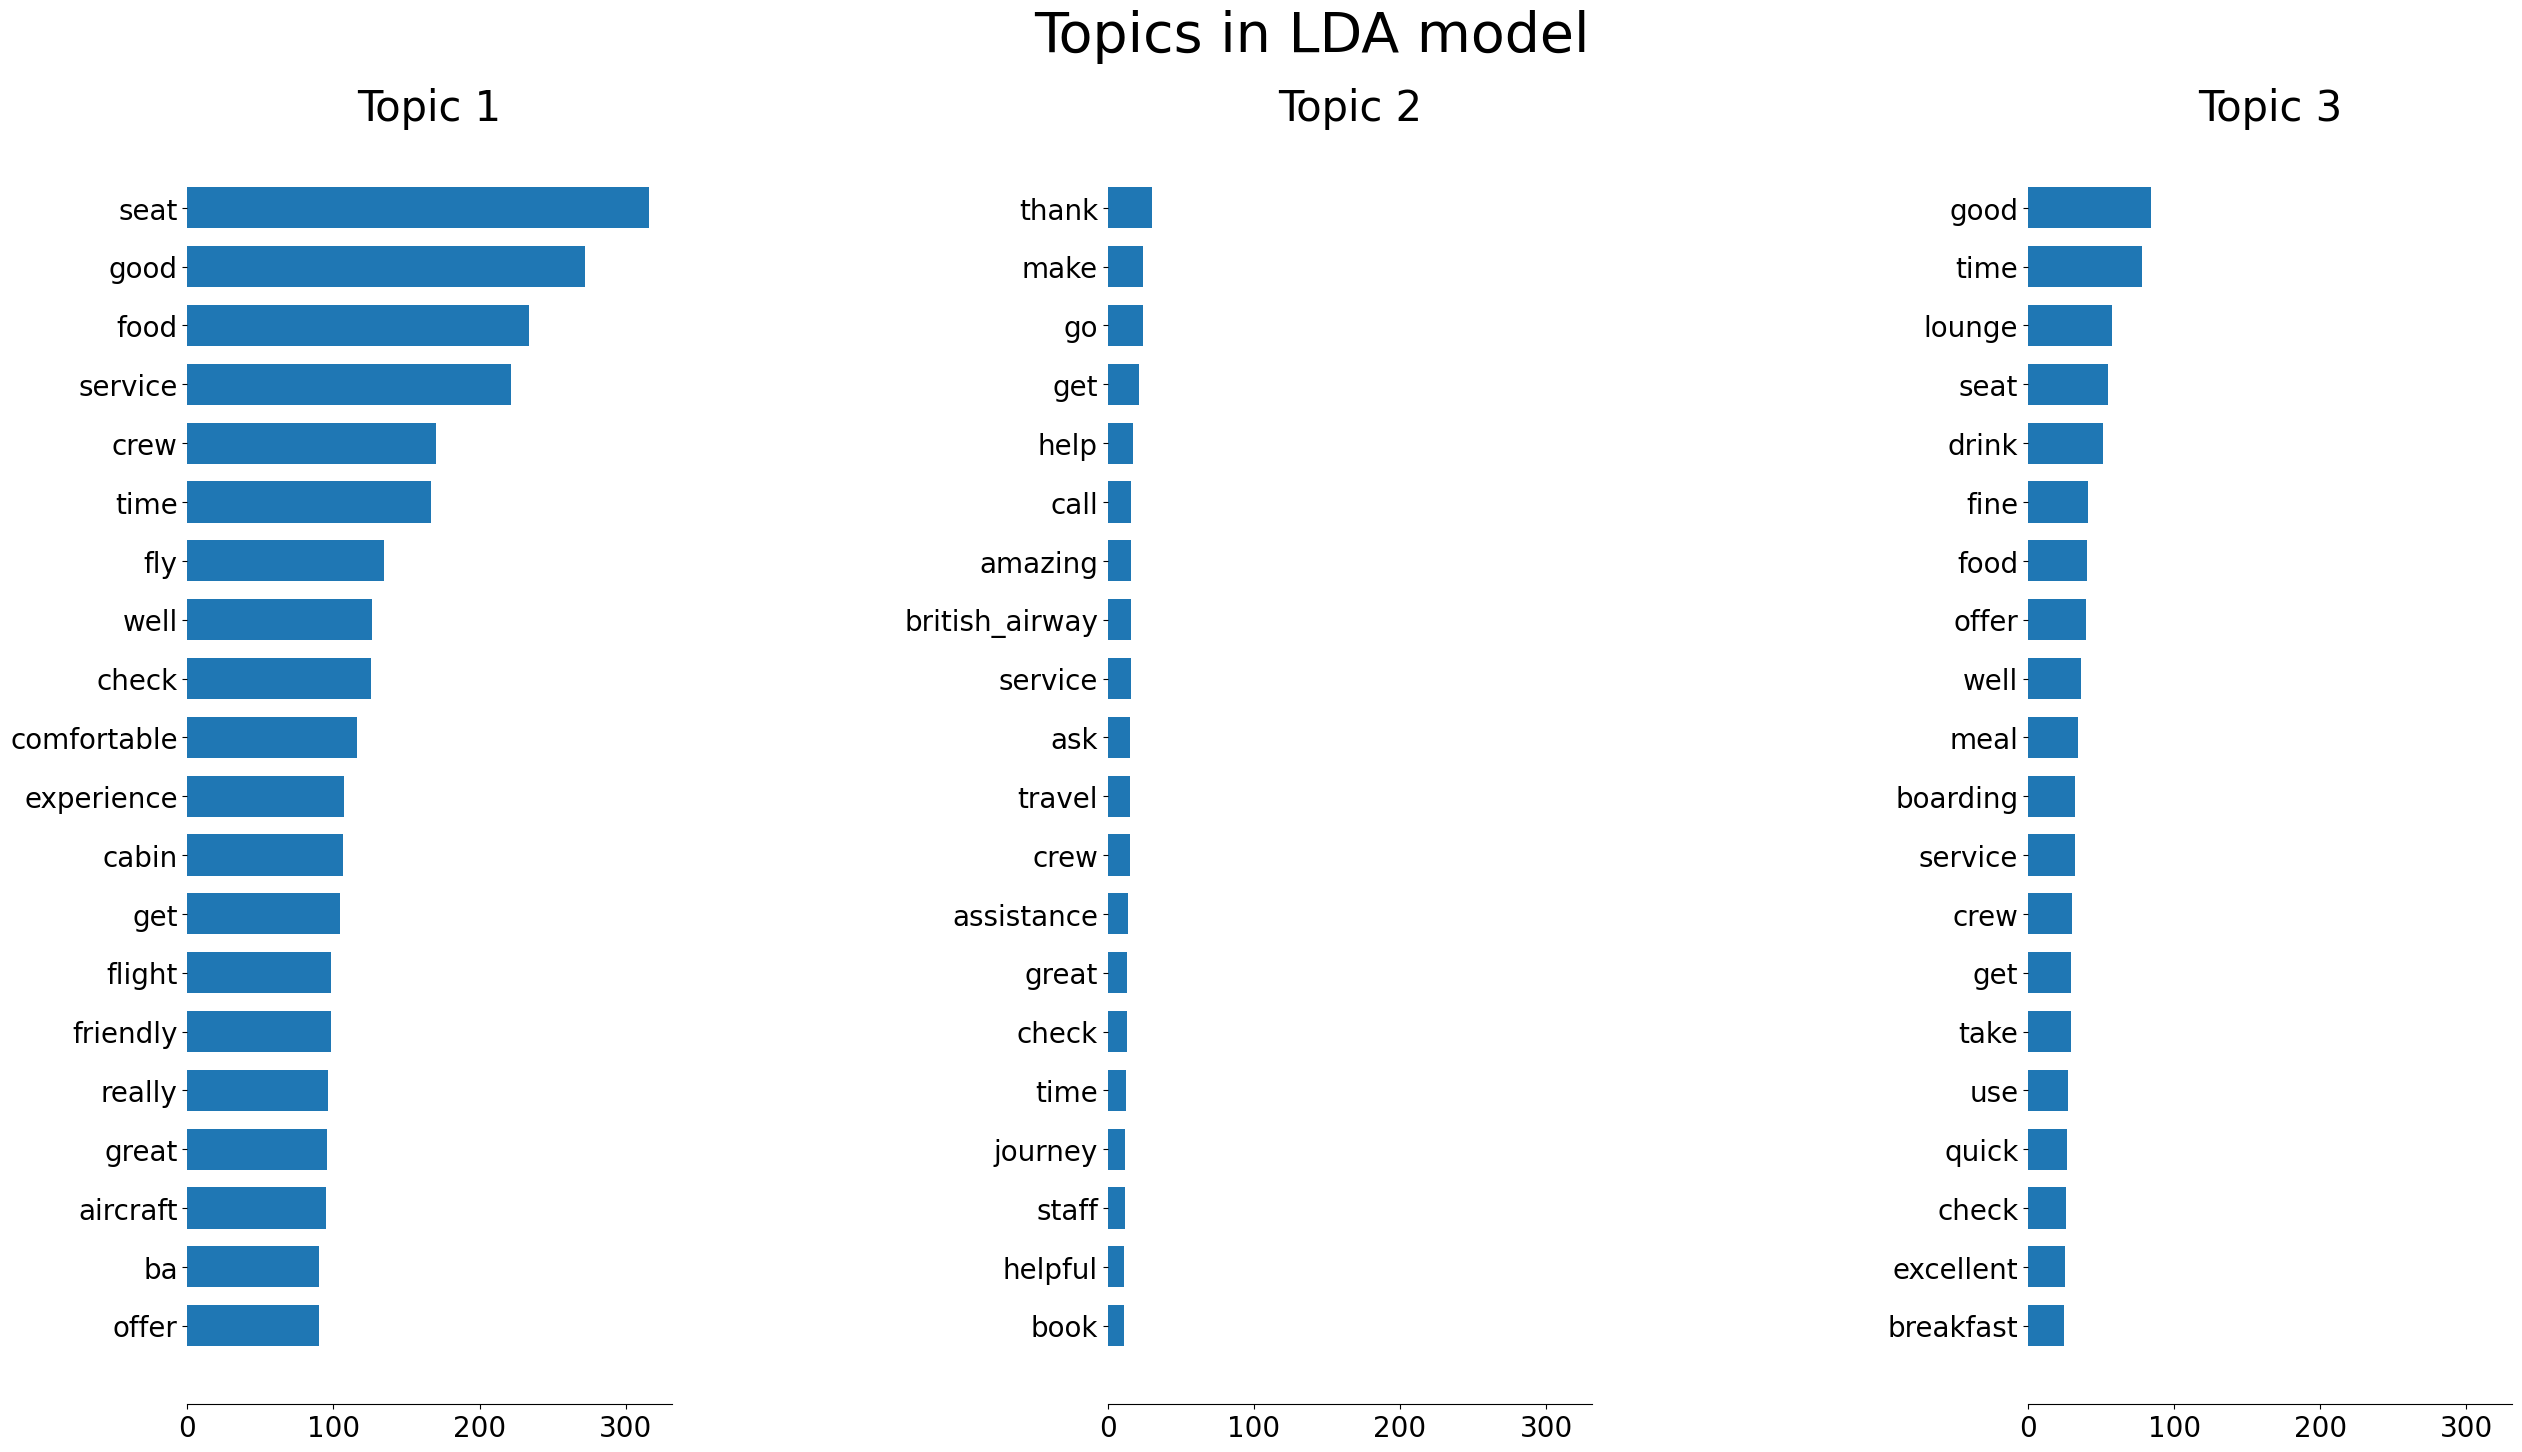

In [46]:
# Visualise the result into bar charts in topic

%matplotlib inline
import matplotlib.pyplot as plt

# helper function to plot topics
# see Grisel et al.
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True) # Here you change the structure of the plot; first number is row and second number is column
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20  #how many words to be visualised in each topic

# get the list of words (feature names)
vec_feature_names = vectorizer_pos.get_feature_names_out() # Make sure you set the right vectorizer name

# print the top words per topic
plot_top_words(lda_pos, vec_feature_names, n_top_words, 'Topics in LDA model') # Make sure you set the right lda model name

### 4.2 Visualise the topics out of negative review

We use `vectorizer_neg` to name the vectorizer. Thus,

`terms = vectorizer_neg.get_feature_names_out()`

And we use `lda_neg` to name the lda model. Thus,

`for idx,topic in enumerate(lda_neg.components_)`


Also, we change the topic number to 3. Thus,

`fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True) `

(we change the row to 1 and column to 3)

Topic#  1
check,staff,time,make,delay,ba,arrive,least,attitude,minute,airport,mile,terminal,call,online,queue,hour,bus,service,provide,information,catch,people,son,sort,gate,british_airway,recent,passport,process,properly,customer,available,baggage,wait,train,actual,airline,appal,even,departure,flight,point,security,experience,get,poor,full,expensive,slow

Topic#  2
seat,service,food,get,business_class,fly,staff,passenger,time,hour,offer,plane,airline,take,check,drink,ba,crew,meal,cabin,use,pay,serve,well,good,go,delay,ask,aircraft,make,even,choice,bad,say,experience,economy,give,lounge,water,boarding,board,poor,old,leave,small,work,british_airway,travel,flight,really

Topic#  3
get,hour,cancel,book,tell,call,british_airway,say,go,day,customer_service,refund,bag,pay,time,fly,make,delay,give,flight,try,arrive,airport,ticket,travel,check,change,airline,take,find,voucher,luggage,email,ba,wait,due,receive,miss,back,ask,return,phone,still,never,help,issue,lose,seat,customer,need



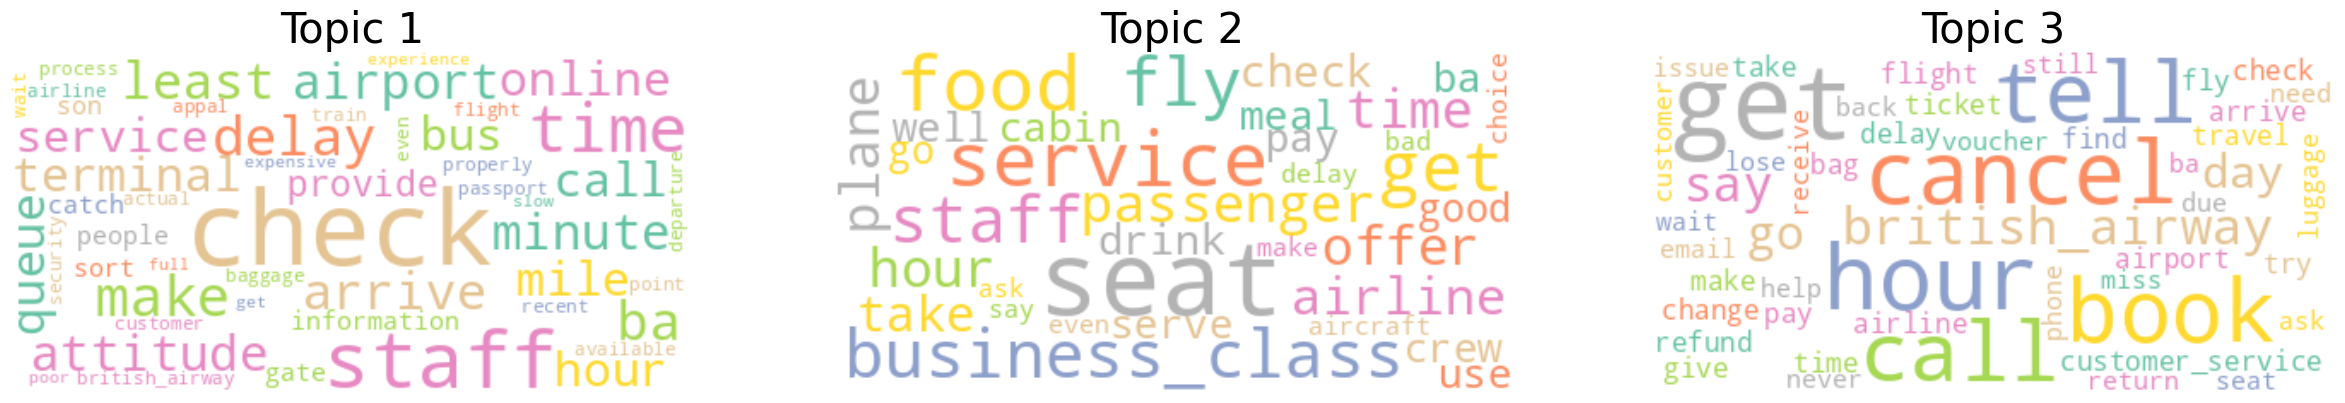

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import wordcloud

#declaring number of terms we need per topic
terms_count = 50

terms = vectorizer_neg.get_feature_names_out() # Make sure you set the right vectorizer name

wcloud = wordcloud.WordCloud(background_color="White",mask=None, max_words=100,\
                             max_font_size=60,min_font_size=10,prefer_horizontal=0.9,
                             contour_width=3,contour_color='Black',colormap='Set2')

fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True) # Here you change the structure of the plot; first number is row and second number is column
axes = axes.flatten()

for idx,topic in enumerate(lda_neg.components_): # Make sure you set the right lda model name
    print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
        topic_words.append(topic_terms_sorted[i][0])
    print(','.join( word for word in topic_words))
    print("")
    dict_word_frequency = {}

    for i in range(terms_count):
        dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]

    ax = axes[idx]
    ax.set_title(f'Topic {idx +1}',fontdict={'fontsize': 30})
    wcloud.generate_from_frequencies(dict_word_frequency)
    ax.imshow(wcloud, interpolation='bilinear')
    ax.axis("off")

Make sure it is `vectorizer_neg` and `lda_neg`

`vec_feature_names = vectorizer_neg.get_feature_names_out()`

`plot_top_words(lda_neg, vec_feature_names, n_top_words, 'Topics in LDA model')`

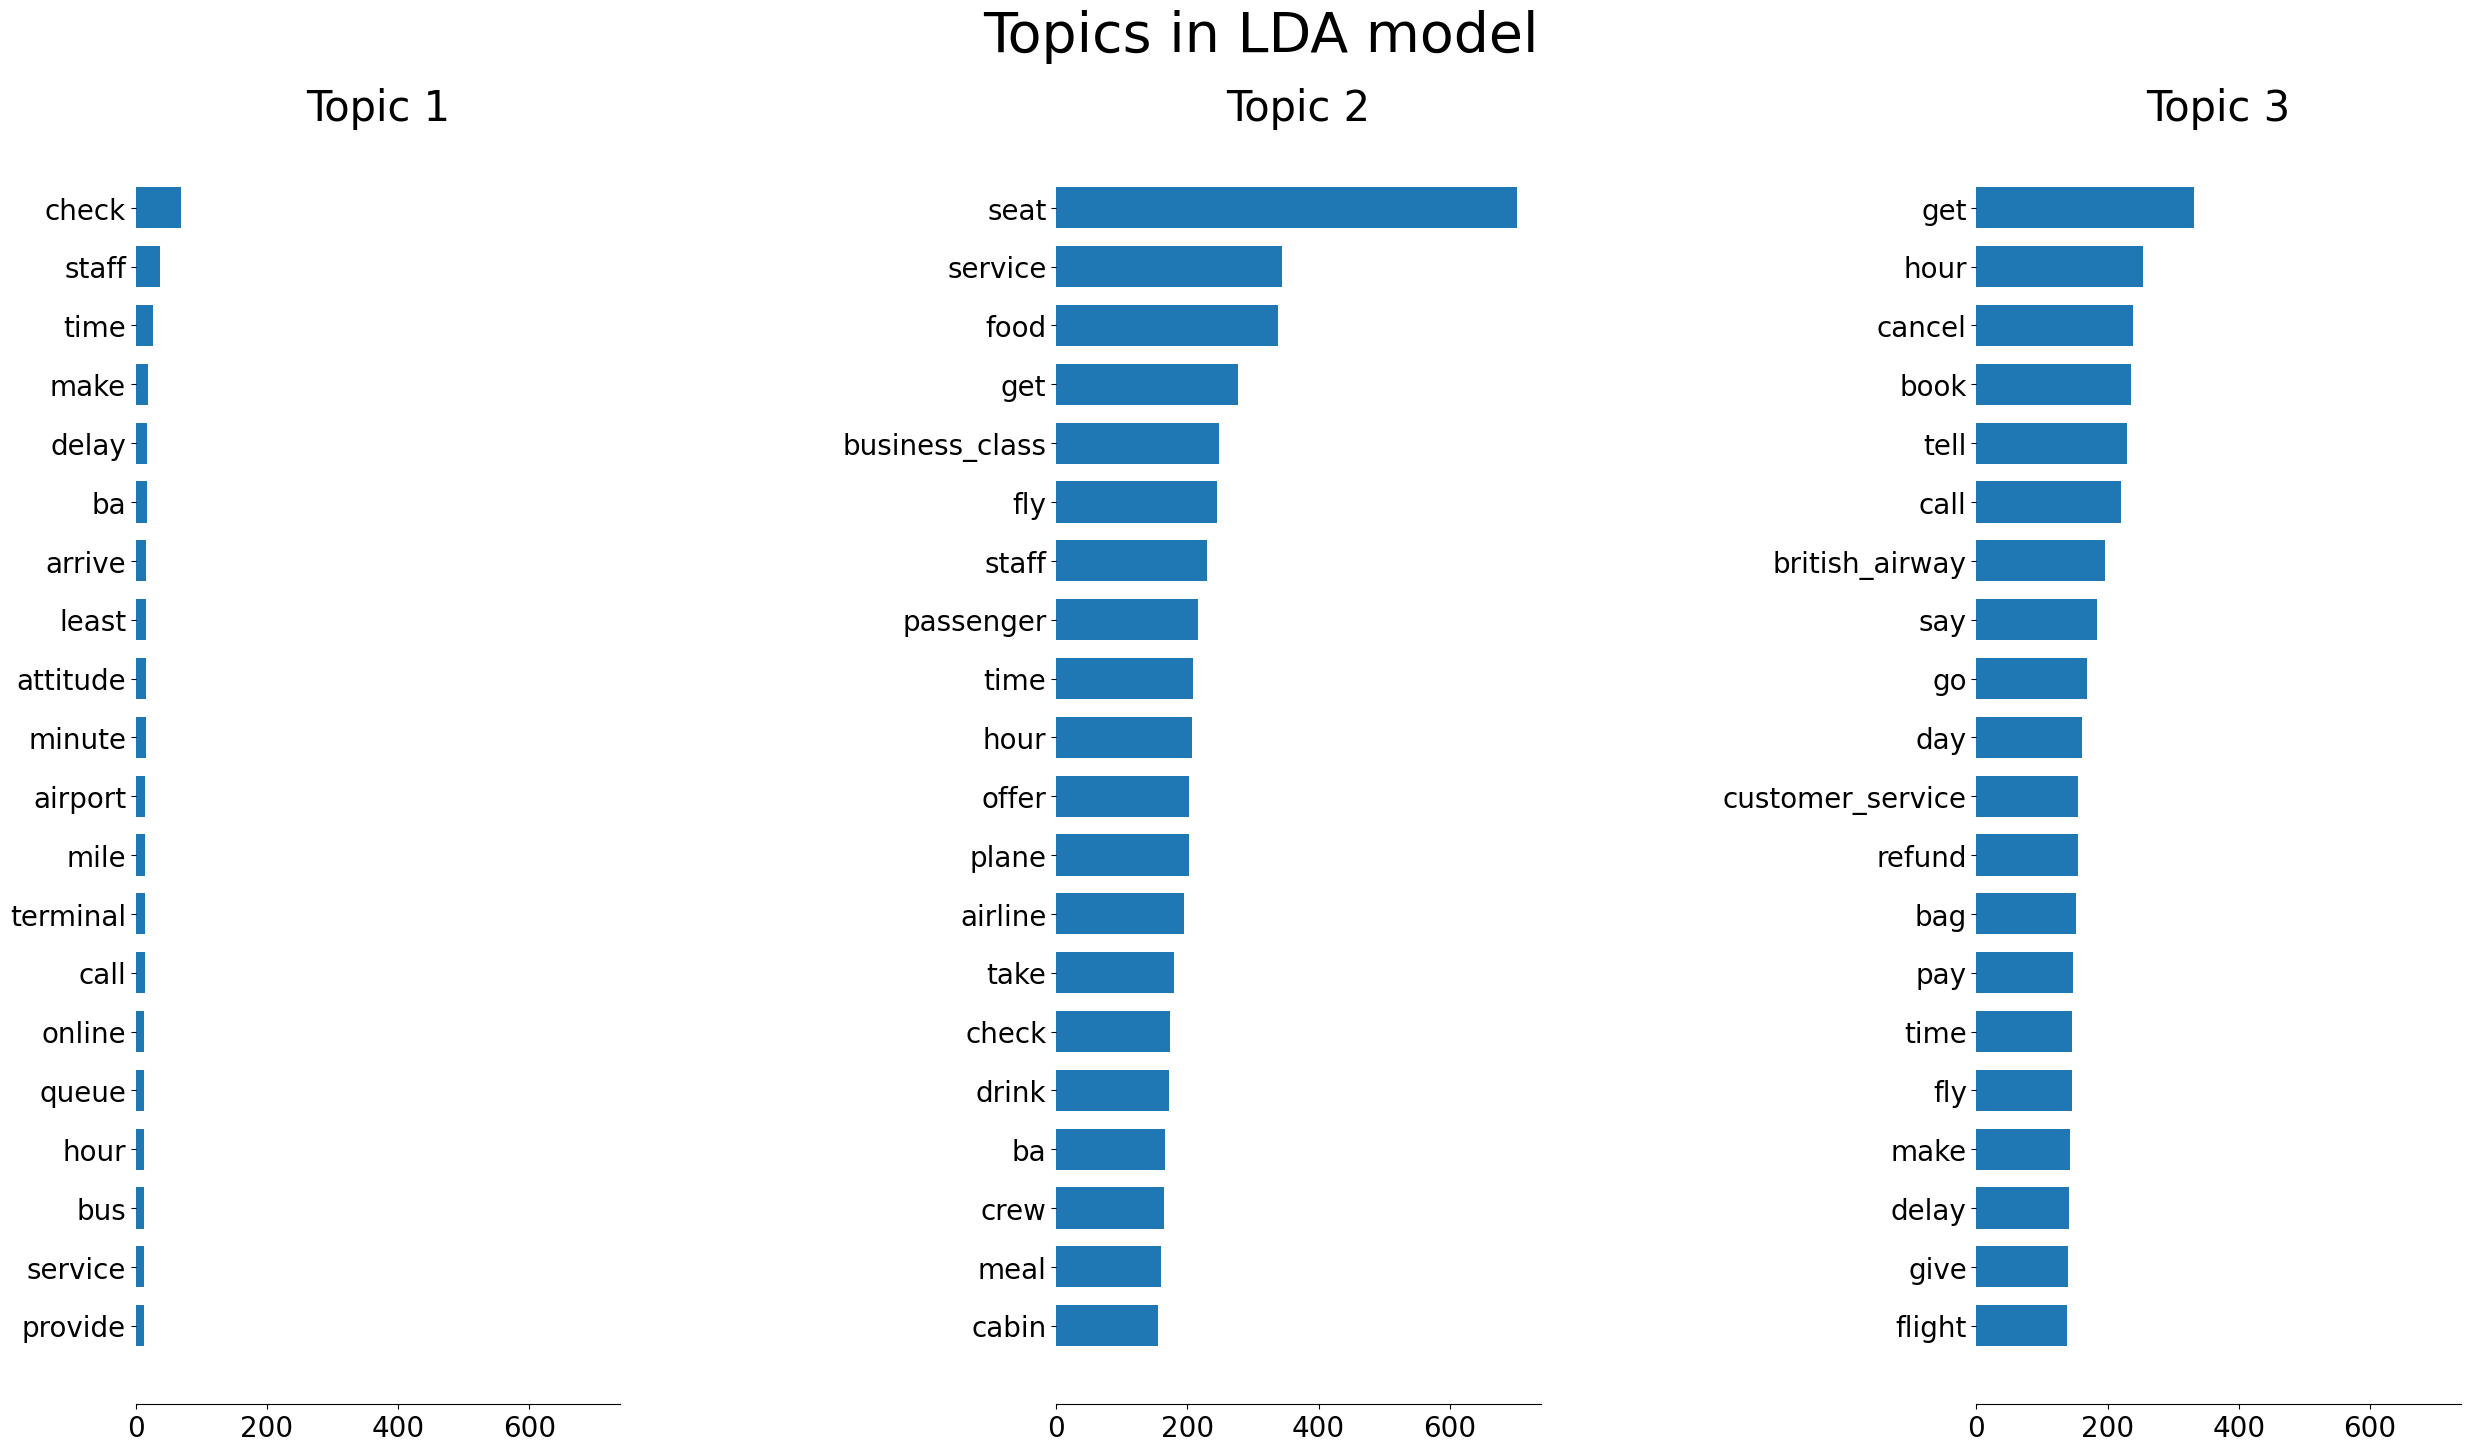

In [47]:
# Visualise the result into bar charts in topic

%matplotlib inline
import matplotlib.pyplot as plt

# helper function to plot topics
# see Grisel et al.
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True) # Here you change the structure of the plot; first number is row and second number is column
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20  #how many words to be visualised in each topic

# get the list of words (feature names)
vec_feature_names = vectorizer_neg.get_feature_names_out() # Make sure you set the right vectorizer name

# print the top words per topic
plot_top_words(lda_neg, vec_feature_names, n_top_words, 'Topics in LDA model') # Make sure you set the right lda model name

## **5. Download file with assigned topic**

Download the file with positive review with assigned topics

In [ ]:
doc_topic = lda_pos.transform(vec_pos)
docsVStopics = pd.DataFrame(doc_topic, columns=["Topic"+str(i+1) for i in range(k)])
df = df.join(docsVStopics)
df['mostlikely_topic'] = docsVStopics.idxmax(axis=1)

df.to_csv('topic_modeling_result.csv', index=False) # save the file to google drive
files.download('topic_modeling_result.csv') # download the file to your local machine

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download the file with negative review with assigned topics

In [ ]:
doc_topic = lda_neg.transform(vec_neg)
docsVStopics = pd.DataFrame(doc_topic, columns=["Topic"+str(i+1) for i in range(k)])
df = df.join(docsVStopics)
df['mostlikely_topic'] = docsVStopics.idxmax(axis=1)

df.to_csv('topic_modeling_result.csv', index=False) # save the file to google drive
files.download('topic_modeling_result.csv') # download the file to your local machine